In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from datetime import datetime
from datetime import timedelta
from random import sample
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 100)

In [132]:
df_loc_prod = pd.read_csv(r"C:\Users\2001_\Desktop\course\loc_prod.csv", sep=',')
df_loc = pd.read_csv(r"C:\Users\2001_\Desktop\course\loc.csv", sep=',')
df_prod = pd.read_csv(r"C:\Users\2001_\Desktop\course\prod.csv", sep=',')

In [133]:
comp = pd.DataFrame({'name':[], 'MAE_all':[], 'RMSE_all':[], 'WAPE_all':[], 'good_intersect_count':[],
                     'MAE_intersect':[], 'RMSE_intersect':[], 'WAPE_intersect':[],'good_difference':[]})

In [134]:
good_loc_prod = df_loc_prod[(df_loc_prod.Elasticity > -10) & (df_loc_prod.Elasticity < 0) & (df_loc_prod.P_value < 0.05)].reset_index()

# Ошибки для модели на товарах

In [135]:
temp_prod = df_loc_prod.merge(df_prod, how='left', on='product_id')

In [136]:
temp_prod[(temp_prod.Elasticity_y > -10) & (temp_prod.Elasticity_y < 0) & (temp_prod.P_value_y < 0.05) & (
(temp_prod.Elasticity_x <= -10) | (temp_prod.Elasticity_x >= 0) | (temp_prod.P_value_x >= 0.05))].shape[0]

30

In [137]:
temp_prod_good = good_loc_prod.merge(df_prod, how='inner', on='product_id')

In [138]:
good_prod = df_prod[(df_prod.Elasticity > -10) & (df_prod.Elasticity < 0) & (df_prod.P_value < 0.05)].reset_index()

In [139]:
temp_prod_good_intersect = good_loc_prod.merge(good_prod, how='inner', on='product_id')

In [140]:
comp = comp.append({'name':'df_prod', 'MAE_all': 1/temp_prod_good.shape[0]*sum(np.abs(temp_prod_good.Elasticity_x-temp_prod_good.Elasticity_y)),
             'RMSE_all': np.sqrt(1/temp_prod_good.shape[0]*sum((temp_prod_good.Elasticity_x-temp_prod_good.Elasticity_y)**2)),
                    'WAPE_all': (temp_prod_good.Elasticity_x - temp_prod_good.Elasticity_y).abs().sum() / temp_prod_good.Elasticity_x.abs().sum(),
                    'good_intersect_count': temp_prod_good_intersect.shape[0],
                    'MAE_intersect': 1/temp_prod_good_intersect.shape[0]*sum(np.abs(temp_prod_good_intersect.Elasticity_x-temp_prod_good_intersect.Elasticity_y)),
             'RMSE_intersect': np.sqrt(1/temp_prod_good_intersect.shape[0]*sum((temp_prod_good_intersect.Elasticity_x-temp_prod_good_intersect.Elasticity_y)**2)),
                    'WAPE_intersect': (temp_prod_good_intersect.Elasticity_x - temp_prod_good_intersect.Elasticity_y).abs().sum() / temp_prod_good_intersect.Elasticity_x.abs().sum(),
             'good_difference': 30}, ignore_index = True)


# Ошибки для модели на магазинах

In [141]:
temp_loc = df_loc_prod.merge(df_loc, how='left', on='LOCATION_id')

In [142]:
temp_loc[(temp_loc.Elasticity_y > -10) & (temp_loc.Elasticity_y < 0) & (temp_loc.P_value_y < 0.05) & (
(temp_loc.Elasticity_x <= -10) | (temp_loc.Elasticity_x >= 0) | (temp_loc.P_value_x >= 0.05))].shape[0]

26

In [143]:
temp_loc_good = good_loc_prod.merge(df_loc, how='inner', on='LOCATION_id')

In [144]:
good_loc = df_loc[(df_loc.Elasticity > -10) & (df_loc.Elasticity < 0) & (df_loc.P_value < 0.05)].reset_index()

In [145]:
temp_loc_good_intersect = good_loc_prod.merge(good_loc, how='inner', on='LOCATION_id')

In [146]:
comp = comp.append({'name':'df_loc', 'MAE_all': 1/temp_loc_good.shape[0]*sum(np.abs(temp_loc_good.Elasticity_x-temp_loc_good.Elasticity_y)),
             'RMSE_all': np.sqrt(1/temp_loc_good.shape[0]*sum((temp_loc_good.Elasticity_x-temp_loc_good.Elasticity_y)**2)),
                    'WAPE_all': (temp_loc_good.Elasticity_x - temp_loc_good.Elasticity_y).abs().sum() / temp_loc_good.Elasticity_x.abs().sum(),
                    'good_intersect_count': temp_loc_good_intersect.shape[0],
                    'MAE_intersect': 1/temp_loc_good_intersect.shape[0]*sum(np.abs(temp_loc_good_intersect.Elasticity_x-temp_loc_good_intersect.Elasticity_y)),
             'RMSE_intersect': np.sqrt(1/temp_loc_good_intersect.shape[0]*sum((temp_loc_good_intersect.Elasticity_x-temp_loc_good_intersect.Elasticity_y)**2)),
                    'WAPE_intersect': (temp_loc_good_intersect.Elasticity_x - temp_loc_good_intersect.Elasticity_y).abs().sum() / temp_loc_good_intersect.Elasticity_x.abs().sum(),
             'good_difference': 26}, ignore_index = True)


In [147]:
df_for_test = pd.read_csv(r"C:\Users\2001_\Desktop\course\df_for_test.csv", sep=',')
popular_pairs = pd.read_csv(r"C:\Users\2001_\Desktop\course\popular_pairs.csv", sep=',')

# Методы для построения моделей

In [148]:
pairs_for_experiment = []
num_of_pairs = 290
for i, r in popular_pairs.iterrows():
    if i == num_of_pairs:
        break
    pairs_for_experiment.append((r['product_id'], r['LOCATION_id']))

In [149]:
def transform(x):
    return np.log1p(x)
 

In [150]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params['PRICE_REG']

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues['PRICE_REG']

In [151]:
def elasticity(X, y, model):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    return coef(model)

In [152]:
def PEDmodel(X, y):
    '''
    Makes PED model based on input data X, y and model type
    '''
    act_x = transform(X)
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y)
    
    return sm.OLS(act_y, act_x).fit()

In [153]:
def get_model_stats(X, y, model):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model)
    
    return coef(model), pvalue(model), elas

In [154]:
def GeneratePEDModels_onehot(dataset, number):
    product_id, location_id, elas, qty, ttpvalue = [], [], [], [], []
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        data = dataset[(dataset.product_id == good_id) & (dataset.LOCATION_id == shop_id)]
        model = PEDmodel(data[['PRICE_REG','Feb23','May1','Jun12','Nov4','NY'] + list('clust_' + str(i) for i in range(number))], data.TGT_QTY)
        c, tp, e = get_model_stats(data[['PRICE_REG','Feb23','May1','Jun12','Nov4','NY'] + list('clust_' + str(i) for i in range(number))], data.TGT_QTY, model)

        product_id.append(good_id)
        location_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        qty.append(data.TGT_QTY.sum()/data.shape[0])
    
    return pd.DataFrame({
        'product_id': product_id,
        'LOCATION_id': location_id,
        'Elasticity': elas,
        'Qty': qty,
        'P_value': ttpvalue
    })

In [155]:
def GeneratePEDModels_numbers(dataset):
    product_id, location_id, elas, qty, ttpvalue = [], [], [], [], []
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        data = dataset[(dataset.product_id == good_id) & (dataset.LOCATION_id == shop_id)]
        model = PEDmodel(data[['PRICE_REG','Feb23','May1','Jun12','Nov4','NY','clusters']], data.TGT_QTY)
        c, tp, e = get_model_stats(data[['PRICE_REG','Feb23','May1','Jun12','Nov4','NY','clusters']], data.TGT_QTY, model)

        product_id.append(good_id)
        location_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        qty.append(data.TGT_QTY.sum()/data.shape[0])
    
    return pd.DataFrame({
        'product_id': product_id,
        'LOCATION_id': location_id,
        'Elasticity': elas,
        'Qty': qty,
        'P_value': ttpvalue
    })

In [156]:
def GeneratePEDModels_enrich_numbers(dataset, pop_clust):
    product_id, location_id, elas, qty, ttpvalue, counts, cluster_enrich = [], [], [], [], [], [],[]
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        temp_data = pop_clust[(pop_clust.product_id == good_id) & (pop_clust.LOCATION_id == shop_id)]
        temp = int(temp_data['cluster'].values)
        data = dataset[(dataset.product_id == good_id) & (dataset.LOCATION_id == shop_id)]
        enrich = dataset[dataset.clusters == temp]
        data = pd.concat([data, enrich], ignore_index=True)
        data = data.drop_duplicates()
        model = PEDmodel(data[['PRICE_REG','Feb23','May1','Jun12','Nov4','NY','clusters']], data.TGT_QTY)
        c, tp, e = get_model_stats(data[['PRICE_REG','Feb23','May1','Jun12','Nov4','NY','clusters']], data.TGT_QTY, model)

        product_id.append(good_id)
        location_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        qty.append(data.TGT_QTY.sum()/data.shape[0])
        counts.append(data.shape[0])
        cluster_enrich.append(temp)
    
    return pd.DataFrame({
        'product_id': product_id,
        'LOCATION_id': location_id,
        'Elasticity': elas,
        'Qty': qty,
        'P_value': ttpvalue,
        'counts': counts,
        'cluster_enrich': cluster_enrich
    })

In [157]:
def GeneratePEDModels_enrich(dataset, pop_clust):
    product_id, location_id, elas, qty, ttpvalue, counts, cluster_enrich = [], [], [], [], [], [],[]
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        temp_data = pop_clust[(pop_clust.product_id == good_id) & (pop_clust.LOCATION_id == shop_id)]
        temp = int(temp_data['cluster'].values)
        data = dataset[(dataset.product_id == good_id) & (dataset.LOCATION_id == shop_id)]
        enrich = dataset[dataset.clusters == temp]
        data = pd.concat([data, enrich], ignore_index=True)
        data = data.drop_duplicates()
        model = PEDmodel(data[['PRICE_REG','Feb23','May1','Jun12','Nov4','NY']], data.TGT_QTY)
        c, tp, e = get_model_stats(data[['PRICE_REG','Feb23','May1','Jun12','Nov4','NY']], data.TGT_QTY, model)

        product_id.append(good_id)
        location_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        qty.append(data.TGT_QTY.sum()/data.shape[0])
        counts.append(data.shape[0])
        cluster_enrich.append(temp)
    
    return pd.DataFrame({
        'product_id': product_id,
        'LOCATION_id': location_id,
        'Elasticity': elas,
        'Qty': qty,
        'P_value': ttpvalue,
        'counts': counts,
        'cluster_enrich': cluster_enrich
    })

# Эксперимент с различными методами сегментации для подсчета эластичности без TSNE

In [158]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib import cm
from sklearn.manifold import TSNE

In [159]:
for i in range(5, 55, 5):
    df_for_clast = pd.DataFrame({'Qty' : np.log1p(df_for_test['TGT_QTY']), 'Price' : np.log1p(df_for_test['PRICE_REG'])})
    gmm = GaussianMixture(n_components=i)
    gmm_y = gmm.fit_predict(df_for_clast)
    new_df_for_test = df_for_test
    for j in range (0, i):
        new_df_for_test[f'clust_{j}'] = 0
    for j in range (len(gmm_y)):
        if(gmm_y[j]!=0):
            new_df_for_test[f'clust_{gmm_y[j]}'][j] = 1
    new_df_for_test['clusters'] = gmm_y
    df_loc_prod_onehot = GeneratePEDModels_onehot(new_df_for_test, i)
    df_loc_prod_onehot = df_loc_prod_onehot.merge(popular_pairs)
    df_loc_prod_numbers = GeneratePEDModels_numbers(new_df_for_test)
    df_loc_prod_numbers = df_loc_prod_numbers.merge(popular_pairs)
    pop_clust = pd.DataFrame(columns = {'product_id', 'LOCATION_id', 'cluster'})
    for good_id, shop_id in pairs_for_experiment:
        data = new_df_for_test[(new_df_for_test.product_id == good_id) & (new_df_for_test.LOCATION_id == shop_id)]
        popular_clusters = data.groupby(['clusters']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)
        temp = {'product_id':good_id, 'LOCATION_id':shop_id, 'cluster':popular_clusters['clusters'][0]}
        pop_clust = pop_clust.append(temp, ignore_index=True)
    df_loc_prod_enrich = GeneratePEDModels_enrich(new_df_for_test, pop_clust)
    df_loc_prod_enrich_numbers = GeneratePEDModels_enrich_numbers(new_df_for_test, pop_clust)
    tables = [df_loc_prod_onehot, df_loc_prod_numbers, df_loc_prod_enrich, df_loc_prod_enrich_numbers]
    tables_name = [f'one_hot_{i}', f'numbers_{i}', f'enrich_{i}', f'enrich_numbers_{i}']
    for j in range(len(tables)):
        temp = df_loc_prod.merge(tables[j], how='left', on=['LOCATION_id', 'product_id'])
        diff = temp[(temp.Elasticity_y > -10) & (temp.Elasticity_y < 0) & (temp.P_value_y < 0.05) & (
        (temp.Elasticity_x <= -10) | (temp.Elasticity_x >= 0) | (temp.P_value_x >= 0.05))].shape[0]
        temp_pl = good_loc_prod.merge(tables[j], how='inner', on=['LOCATION_id', 'product_id']) 
        good_pl = tables[j][(tables[j].Elasticity > -10) & (tables[j].Elasticity < 0) & (tables[j].P_value < 0.05)].reset_index()
        temp_pl_intersect = good_loc_prod.merge(good_pl, how='inner', on=['LOCATION_id', 'product_id'])
   
    
        comp = comp.append({'name':tables_name[j], 'MAE_all': 1/temp_pl.shape[0]*sum(np.abs(temp_pl.Elasticity_x-temp_pl.Elasticity_y)),
                 'RMSE_all': np.sqrt(1/temp_pl.shape[0]*sum((temp_pl.Elasticity_x-temp_pl.Elasticity_y)**2)),
                        'WAPE_all': (temp_pl.Elasticity_x - temp_pl.Elasticity_y).abs().sum() / temp_pl.Elasticity_x.abs().sum(),
                        'good_intersect_count': temp_pl_intersect.shape[0],
                        'MAE_intersect': 1/temp_pl_intersect.shape[0]*sum(np.abs(temp_pl_intersect.Elasticity_x-temp_pl_intersect.Elasticity_y)),
                 'RMSE_intersect': np.sqrt(1/temp_pl_intersect.shape[0]*sum((temp_pl_intersect.Elasticity_x-temp_pl_intersect.Elasticity_y)**2)),
                        'WAPE_intersect': (temp_pl_intersect.Elasticity_x - temp_pl_intersect.Elasticity_y).abs().sum() / temp_pl_intersect.Elasticity_x.abs().sum(),
                 'good_difference': diff}, ignore_index = True)


C:\Users\2001_\AppData\Local\Temp/ipykernel_18088/3134004836.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_for_test[f'clust_{gmm_y[j]}'][j] = 1
C:\Users\2001_\AppData\Local\Temp/ipykernel_18088/3134004836.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_for_test[f'clust_{gmm_y[j]}'][j] = 1
C:\Users\2001_\AppData\Local\Temp/ipykernel_18088/3134004836.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_fo

# Эксперимент с различными методами сегментации для подсчета эластичности с применением TSNE

In [160]:
for i in range(5, 55, 5):
    df_for_clast = pd.DataFrame({'Qty' : np.log1p(df_for_test['TGT_QTY']), 'Price' : np.log1p(df_for_test['PRICE_REG'])})
    n_components = 2
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(df_for_clast[['Qty','Price']])
    gmm = GaussianMixture(n_components=i)
    gmm_y = gmm.fit_predict(tsne_result)
    new_df_for_test = df_for_test
    for j in range (0, i):
        new_df_for_test[f'clust_{j}'] = 0
    for j in range (len(gmm_y)):
        if(gmm_y[j]!=0):
            new_df_for_test[f'clust_{gmm_y[j]}'][j] = 1
    new_df_for_test['clusters'] = gmm_y
    df_loc_prod_onehot = GeneratePEDModels_onehot(new_df_for_test, i)
    df_loc_prod_onehot = df_loc_prod_onehot.merge(popular_pairs)
    df_loc_prod_numbers = GeneratePEDModels_numbers(new_df_for_test)
    df_loc_prod_numbers = df_loc_prod_numbers.merge(popular_pairs)
    pop_clust = pd.DataFrame(columns = {'product_id', 'LOCATION_id', 'cluster'})
    for good_id, shop_id in pairs_for_experiment:
        data = new_df_for_test[(new_df_for_test.product_id == good_id) & (new_df_for_test.LOCATION_id == shop_id)]
        popular_clusters = data.groupby(['clusters']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)
        temp = {'product_id':good_id, 'LOCATION_id':shop_id, 'cluster':popular_clusters['clusters'][0]}
        pop_clust = pop_clust.append(temp, ignore_index=True)
    df_loc_prod_enrich = GeneratePEDModels_enrich(new_df_for_test, pop_clust)
    df_loc_prod_enrich_numbers = GeneratePEDModels_enrich_numbers(new_df_for_test, pop_clust)
    tables = [df_loc_prod_onehot, df_loc_prod_numbers, df_loc_prod_enrich, df_loc_prod_enrich_numbers]
    tables_name = [f'one_hot_tsne{i}', f'numbers_tsne{i}', f'enrich_tsne{i}', f'enrich_numbers_tsne{i}']
    for j in range(len(tables)):
        temp = df_loc_prod.merge(tables[j], how='left', on=['LOCATION_id', 'product_id'])
        diff = temp[(temp.Elasticity_y > -10) & (temp.Elasticity_y < 0) & (temp.P_value_y < 0.05) & (
        (temp.Elasticity_x <= -10) | (temp.Elasticity_x >= 0) | (temp.P_value_x >= 0.05))].shape[0]
        temp_pl = good_loc_prod.merge(tables[j], how='inner', on=['LOCATION_id', 'product_id']) 
        good_pl = tables[j][(tables[j].Elasticity > -10) & (tables[j].Elasticity < 0) & (tables[j].P_value < 0.05)].reset_index()
        temp_pl_intersect = good_loc_prod.merge(good_pl, how='inner', on=['LOCATION_id', 'product_id'])
   
    
        comp = comp.append({'name':tables_name[j], 'MAE_all': 1/temp_pl.shape[0]*sum(np.abs(temp_pl.Elasticity_x-temp_pl.Elasticity_y)),
                 'RMSE_all': np.sqrt(1/temp_pl.shape[0]*sum((temp_pl.Elasticity_x-temp_pl.Elasticity_y)**2)),
                        'WAPE_all': (temp_pl.Elasticity_x - temp_pl.Elasticity_y).abs().sum() / temp_pl.Elasticity_x.abs().sum(),
                        'good_intersect_count': temp_pl_intersect.shape[0],
                        'MAE_intersect': 1/temp_pl_intersect.shape[0]*sum(np.abs(temp_pl_intersect.Elasticity_x-temp_pl_intersect.Elasticity_y)),
                 'RMSE_intersect': np.sqrt(1/temp_pl_intersect.shape[0]*sum((temp_pl_intersect.Elasticity_x-temp_pl_intersect.Elasticity_y)**2)),
                        'WAPE_intersect': (temp_pl_intersect.Elasticity_x - temp_pl_intersect.Elasticity_y).abs().sum() / temp_pl_intersect.Elasticity_x.abs().sum(),
                 'good_difference': diff}, ignore_index = True)


C:\Users\2001_\AppData\Local\Temp/ipykernel_18088/1683383324.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_for_test[f'clust_{gmm_y[j]}'][j] = 1
C:\Users\2001_\AppData\Local\Temp/ipykernel_18088/1683383324.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_for_test[f'clust_{gmm_y[j]}'][j] = 1
C:\Users\2001_\AppData\Local\Temp/ipykernel_18088/1683383324.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_fo

In [161]:
round_comp  = round(comp, 2)

In [166]:
round_comp

,name,MAE_all,RMSE_all,WAPE_all,good_intersect_count,MAE_intersect,RMSE_intersect,WAPE_intersect,good_difference
0,df_prod,1.11,1.79,0.62,15.0,0.56,0.86,0.32,30.0
1,df_loc,1.31,1.85,0.73,9.0,0.69,1.09,0.38,26.0
2,one_hot_5,1.45,1.75,0.81,9.0,1.21,1.61,0.61,9.0
3,numbers_5,0.94,1.46,0.52,13.0,0.43,0.70,0.25,26.0
4,enrich_5,1.84,2.09,1.02,9.0,1.84,2.04,0.93,52.0
5,enrich_numbers_5,1.85,2.09,1.03,6.0,1.50,1.58,0.89,52.0
6,one_hot_10,1.77,2.10,0.98,5.0,1.62,1.85,0.63,12.0
7,numbers_10,1.22,2.32,0.68,16.0,0.47,0.71,0.29,36.0
8,enrich_10,1.94,2.14,1.08,5.0,2.63,2.76,0.96,30.0
9,enrich_numbers_10,1.94,2.15,1.08,4.0,2.46,2.59,0.96,19.0


In [173]:
round_comp.to_csv(r"C:\Users\2001_\Desktop\course\experiment.csv", sep=',', index = False)

In [3]:
round_comp = pd.read_csv(r"C:\Users\2001_\Desktop\course\experiment.csv", sep=',')

# Таблица с полученными результатами

In [100]:
round_comp.sort_values(by='WAPE_all')

,MAE_all,RMSE_all,WAPE_all,good_intersect_count,MAE_intersect,RMSE_intersect,WAPE_intersect,good_difference
name,,,,,,,,
numbers_tsne10,0.44,0.69,0.24,17.0,0.24,0.30,0.14,45.0
numbers_tsne35,0.45,0.90,0.25,19.0,0.26,0.39,0.14,62.0
numbers_50,0.47,0.82,0.26,16.0,0.30,0.72,0.18,53.0
numbers_tsne40,0.47,0.73,0.26,17.0,0.49,0.80,0.25,46.0
numbers_30,0.47,0.72,0.26,17.0,0.37,0.65,0.24,59.0
numbers_tsne45,0.61,1.15,0.34,17.0,0.67,1.28,0.42,49.0
numbers_25,0.61,1.04,0.34,17.0,0.42,0.70,0.24,66.0
numbers_tsne50,0.61,1.61,0.34,17.0,0.24,0.34,0.15,57.0
numbers_tsne30,0.64,1.33,0.35,18.0,0.33,0.42,0.21,40.0


In [99]:
round_comp.sort_values(by='good_difference', ascending=False)

,MAE_all,RMSE_all,WAPE_all,good_intersect_count,MAE_intersect,RMSE_intersect,WAPE_intersect,good_difference
name,,,,,,,,
combine_tsne_10,1.43,1.77,0.79,19.0,1.25,1.43,0.74,182.0
enrich_tsne10,1.43,1.77,0.79,19.0,1.25,1.43,0.74,176.0
combine_tsne_5,1.44,1.72,0.80,18.0,1.39,1.71,0.75,169.0
enrich_tsne5,1.44,1.72,0.80,18.0,1.38,1.71,0.75,169.0
combine_tsne_40,1.46,1.82,0.81,14.0,1.23,1.56,0.70,141.0
enrich_tsne40,1.43,1.80,0.80,15.0,1.19,1.51,0.69,139.0
combine_tsne_20,1.49,1.78,0.83,21.0,1.36,1.57,0.81,133.0
enrich_tsne20,1.49,1.79,0.83,21.0,1.36,1.57,0.81,123.0
enrich_tsne15,1.56,1.92,0.86,19.0,1.45,1.87,0.78,115.0


In [5]:
round_comp.rename(index = {"enrich_numbers_5": "combine_5", "enrich_numbers_10": "combine_10",
                           "enrich_numbers_15": "combine_15", "enrich_numbers_15": "combine_15",
                          "enrich_numbers_20": "combine_20", "enrich_numbers_25": "combine_25",
                          "enrich_numbers_30": "combine_30", "enrich_numbers_35": "combine_35",
                          "enrich_numbers_40": "combine_40", "enrich_numbers_45": "combine_45",
                          "enrich_numbers_50": "combine_50", "enrich_numbers_tsne5": "combine_tsne_5",
                          "enrich_numbers_tsne10": "combine_tsne_10", "enrich_numbers_tsne15": "combine_tsne_15",
                          "enrich_numbers_tsne20": "combine_tsne_20", "enrich_numbers_tsne25": "combine_tsne_25",
                          "enrich_numbers_tsne30": "combine_tsne_30", "enrich_numbers_tsne35": "combine_tsne_35",
                          "enrich_numbers_tsne40": "combine_tsne_40", "enrich_numbers_tsne45": "combine_tsne_45",
                          "enrich_numbers_tsne50": "combine_tsne_50"}, inplace = True, errors="raise")

In [4]:
round_comp = round_comp.set_index('name')

In [92]:
round_comp

,MAE_all,RMSE_all,WAPE_all,good_intersect_count,MAE_intersect,RMSE_intersect,WAPE_intersect,good_difference
name,,,,,,,,
df_prod,1.11,1.79,0.62,15.0,0.56,0.86,0.32,30.0
df_loc,1.31,1.85,0.73,9.0,0.69,1.09,0.38,26.0
one_hot_5,1.45,1.75,0.81,9.0,1.21,1.61,0.61,9.0
numbers_5,0.94,1.46,0.52,13.0,0.43,0.70,0.25,26.0
enrich_5,1.84,2.09,1.02,9.0,1.84,2.04,0.93,52.0
combine_5,1.85,2.09,1.03,6.0,1.50,1.58,0.89,52.0
one_hot_10,1.77,2.10,0.98,5.0,1.62,1.85,0.63,12.0
numbers_10,1.22,2.32,0.68,16.0,0.47,0.71,0.29,36.0
enrich_10,1.94,2.14,1.08,5.0,2.63,2.76,0.96,30.0


In [7]:
round_comp['name'] = round_comp.index

# Сравнительный Scatter plot разных методов, X = good_difference, Y = 1-WAPE_all

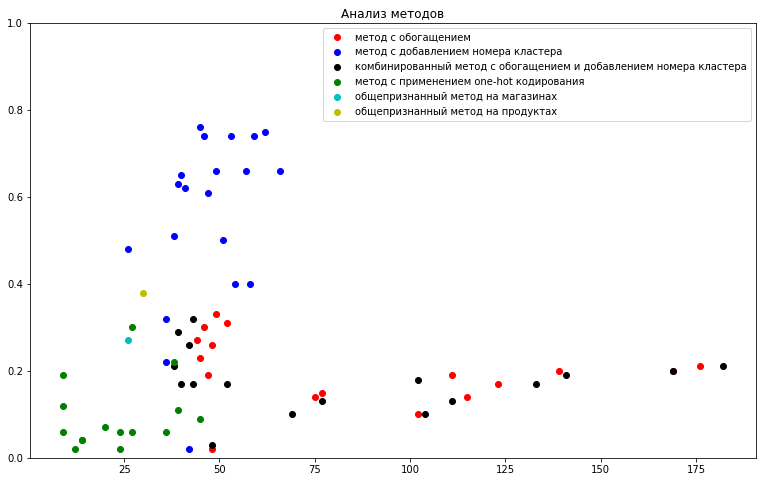

In [12]:
fig, ax = plt.subplots()

ax.scatter(round_comp.loc[round_comp['name'].str.contains(r'enrich')]['good_difference'],
           1-round_comp.loc[round_comp['name'].str.contains(r'enrich')]['WAPE_all'],
           c = 'r', label = 'метод с обогащением')

ax.scatter(round_comp.loc[round_comp['name'].str.contains(r'numbers')]['good_difference'],
           1-round_comp.loc[round_comp['name'].str.contains(r'numbers')]['WAPE_all'],
           c = 'b', label = 'метод с добавлением номера кластера')

ax.scatter(round_comp.loc[round_comp['name'].str.contains(r'combine')]['good_difference'],
           1-round_comp.loc[round_comp['name'].str.contains(r'combine')]['WAPE_all'],
           c = 'k', label = 'комбинированный метод с обогащением и добавлением номера кластера')

ax.scatter(round_comp.loc[round_comp['name'].str.contains(r'one_hot')]['good_difference'],
           1-round_comp.loc[round_comp['name'].str.contains(r'one_hot')]['WAPE_all'],
           c = 'g', label = 'метод с применением one-hot кодирования')

ax.scatter(round_comp.loc[round_comp['name'].str.contains(r'df_loc')]['good_difference'],
           1-round_comp.loc[round_comp['name'].str.contains(r'df_loc')]['WAPE_all'],
           c = 'c', label = 'общепризнанный метод на магазинах')

ax.scatter(round_comp.loc[round_comp['name'].str.contains(r'df_prod')]['good_difference'],
           1-round_comp.loc[round_comp['name'].str.contains(r'df_prod')]['WAPE_all'],
           c = 'y', label = 'общепризнанный метод на продуктах')

ax.set_title('Анализ методов')
ax.legend()
ax.set_ylim((0, 1))

fig.set_figwidth(13)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.show()